# Customer Churn Predictor
## T.A. Aya Saad
## Team Members:
عمر هشام علي عبدالرزاق 

عبدالرحمن محيي محمد رمضان

زياد عاطف شكري صادق

فادي عصام عبدالهادي محمد

إيناس احمد عبدالعظيم رزق

دعاء يحيي اسماعيل حسن

ميرنا عبدالله عبدالسلام عبدالقادر

# Used Modules

In [88]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pickle                                         # Save and Load training models into files
import seaborn as sns                                 # Draw various plots
import missingno as msnum                             # Draw diagram shows the distribution of the null values
from tabulate import tabulate                         # Build tabular output from 2d lists
from sklearn.preprocessing import LabelEncoder        # Perform one label encoding to string values
from sklearn.model_selection import train_test_split  # Split the dataset randomly to test and train 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV
from PyQt5.QtWidgets import * 
from PyQt5.QtGui import * 
from PyQt5.QtCore import * 
import sys

# Global Variables

In [89]:
DATASET_FILE = 'CustomersDataset.csv'

APP_ML_MODELS = ["LOGISTIC_REGRESSION", "SVM", "DECISION_TREE_ID3", "RANDOM_FOREST_TREE"]

APP_MODE = "production"

models = {}

# Helper Function

In [90]:
def arrange_data(model_name, data):
  """ Arrange user input data in dataframe"""
  global label_encoder, dataset, models
  arranged = []

  for feature in dataset.columns[:-1]:
    if feature in label_encoder:
      arranged.append(label_encoder[feature].transform([data[feature]]))
    else:
      arranged.append(np.float64(data[feature]))
  # arranged = np.array(arranged).reshape(1, -1)
  # arranged = models[model_name][1].transform(arranged)
  return pd.DataFrame([arranged])

In [91]:
def evaluate_ml_model(model, x_test, y_test):
  """ Evaluate Classification ML model """
  y_pred = model.predict(x_test)

  score_table = [["Test Score", model.score(x_test, y_test)]]
  score_table.append(["Accuracy", accuracy_score(y_test, y_pred)])
  score_table.append(["Precision", precision_score(y_test, y_pred)])
  score_table.append(["Recall", recall_score(y_test, y_pred)])
        
  print(tabulate(score_table), "\n")
  print(classification_report(y_test, y_pred), "\n")
  # ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  cm = confusion_matrix(y_test, model.predict(x_test), labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot()
  # disp.show()

  return "{0:0.4f}".format(score_table[1][1] * 100)

In [92]:
def save_model(model_name):
  """ Save ML model to file """
  global models
  pickle.dump(models[model_name][0], open("./Models/" + model_name + ".sav", 'wb'))
  pickle.dump(models[model_name][1], open("./Models/" + model_name + "_fs" + ".sav", 'wb'))

def load_model(model_name):
  """ Load a ML model from file """
  global models, fs
  models[model_name] = [
    pickle.load(open("./Models/" + model_name + ".sav", 'rb')),
    pickle.load(open("./Models/" + model_name + "_fs" + ".sav", 'rb'))]

In [93]:
def deploy_model(model_name, data):
  """ Predict the churn using the deployment version of the ml model """
  y_pred = models[model_name][0].predict(arrange_data(model_name, data))
  return label_encoder["Churn"].inverse_transform(y_pred)

In [94]:
def hyperparameter_tuning(model, param_grid):
  """ Perform parameter tuning on a ML model """
  bestModel = [0,0]
  bestScore = 0

  for fs_score_method in ["chi2", "mutual_info"]:
    for num_of_features in range(7, 20):
      x_selected, fs = select_features(fs_score_method, num_of_features, x_data, y_data)
      x_train, x_test, y_train, y_test = split_data(x_selected, y_data)

      grid_search = GridSearchCV(model, param_grid, n_jobs=-1, refit=True)
      grid_search = grid_search.fit(x_train, y_train)

      print(f"Best estimator found by grid search with {fs_score_method} and {num_of_features} features:")
      print("Best Estimator Params: ", grid_search.best_estimator_.get_params())
      print("Best Params: ", grid_search.best_params_) 
      print("Best Score: ", grid_search.best_score_, "\n\n")

      if grid_search.best_score_ > bestScore:
        bestModel[0] = grid_search.best_estimator_
        bestModel[1] = fs
        bestScore = grid_search.best_score_
        print(bestModel)

  return bestModel

# Dataset
________________________________

## Load Dataset

In [95]:
dataset = pd.read_csv(DATASET_FILE)
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Attributes

In [96]:
uniq_table = []

for key in dataset:
  uniq_values = dataset[key].unique()
  uniq_values.sort()
  dtype = (dataset[key].dtype, "string")[dataset[key].dtype == "O"]
  uniq_table.append([key, dtype, len(uniq_values), uniq_values]) 

print(tabulate(uniq_table, headers=["Attribute", "Data Type", "Unique Values Count", "Unique Values"], tablefmt="pipe"))

| Attribute        | Data Type   |   Unique Values Count | Unique Values                                                             |
|:-----------------|:------------|----------------------:|:--------------------------------------------------------------------------|
| customerID       | string      |                  7043 | ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'     |
|                  |             |                       |  '9995-HOTOH']                                                            |
| gender           | string      |                     2 | ['Female' 'Male']                                                         |
| SeniorCitizen    | int64       |                     2 | [0 1]                                                                     |
| Partner          | string      |                     2 | ['No' 'Yes']                                                              |
| Dependents       | string      |                     

# Data Cleansing
____________________________

## Data Type Correction

In [97]:
# Change 'TotalCharges' column data type (String -> Float)
dataset.TotalCharges = pd.to_numeric(dataset.TotalCharges, errors='coerce')
dataset.TotalCharges

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

## Handling Missing Values

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

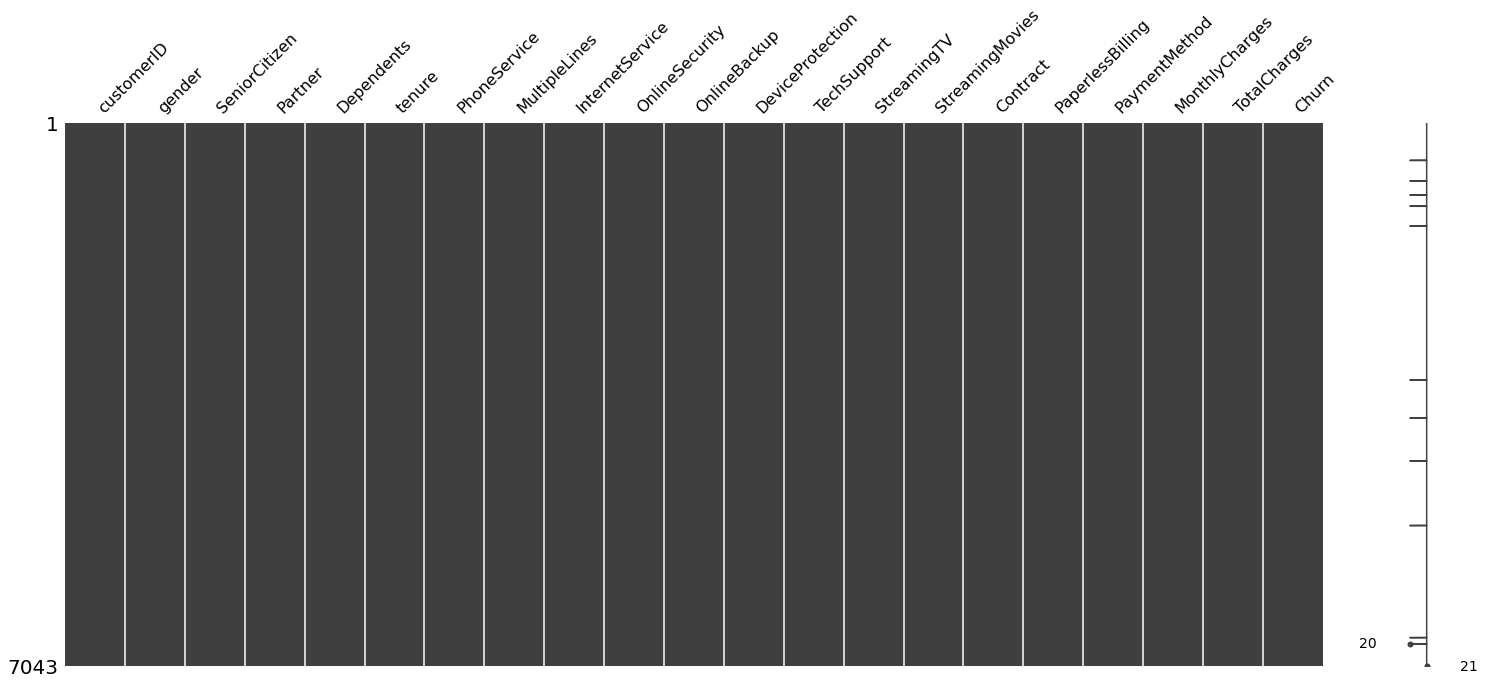

In [98]:
# Check Missing values
msnum.matrix(dataset)
dataset.isnull().sum()

In [99]:
# Calculate the percentage of missing values in TotalCharges column
totalChargesMissingValuesPercent = str(format((dataset.TotalCharges.isnull().sum() / len(dataset.TotalCharges)) * 100, '.2f'))
print(f'Missing values precentage in TotalCharges Column: {totalChargesMissingValuesPercent} %')

Missing values precentage in TotalCharges Column: 0.16 %


In [100]:
# Delete the cases with missing total charges value
dataset.dropna(axis=0, subset=['TotalCharges'], how= 'any', inplace=True )

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

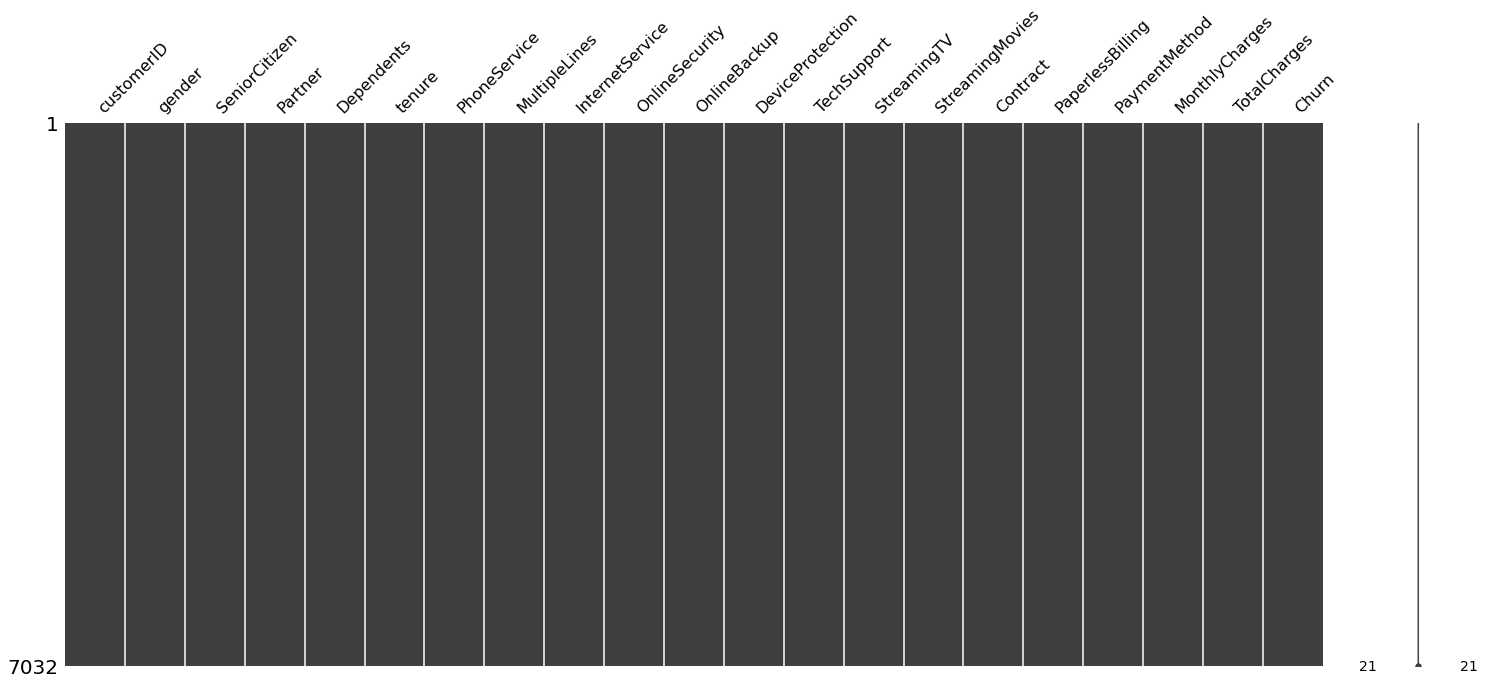

In [101]:
# Verify that the dataset doesn't contain Missing values
msnum.matrix(dataset)
dataset.isnull().sum()

## Mapping String Values 

In [102]:
dataset.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [103]:
# Drop the CustomerID column
dataset = dataset.drop(columns=['customerID'], axis=1)

In [104]:
# Encode Categorical features to numaric values
label_encoder = {}

for feature in dataset:
  if dataset[feature].dtype == "O":
    label_encoder[feature] = LabelEncoder()
    dataset[feature] = label_encoder[feature].fit_transform(dataset[feature])

In [105]:
dataset.dtypes

gender                int32
SeniorCitizen         int64
Partner               int32
Dependents            int32
tenure                int64
PhoneService          int32
MultipleLines         int32
InternetService       int32
OnlineSecurity        int32
OnlineBackup          int32
DeviceProtection      int32
TechSupport           int32
StreamingTV           int32
StreamingMovies       int32
Contract              int32
PaperlessBilling      int32
PaymentMethod         int32
MonthlyCharges      float64
TotalCharges        float64
Churn                 int32
dtype: object

## Remove Extreme Values

<AxesSubplot:>

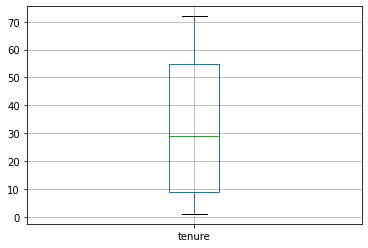

In [106]:
dataset.boxplot(["tenure"])

<AxesSubplot:>

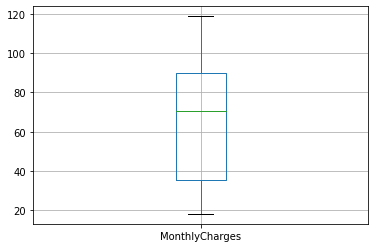

In [107]:
dataset.boxplot(["MonthlyCharges"])

<AxesSubplot:>

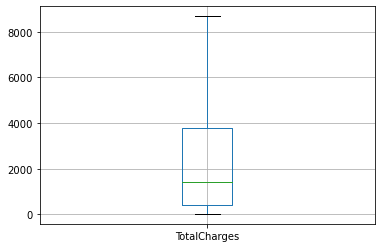

In [108]:
dataset.boxplot(["TotalCharges"])

## Remove Duplicates

In [109]:
print("Dataset before removing duplicates: ", dataset.shape)

Dataset before removing duplicates:  (7032, 20)


In [110]:
dataset.drop_duplicates(inplace=True)

In [111]:
print("Dataset after removing duplicates: ", dataset.shape)

Dataset after removing duplicates:  (7010, 20)


# Gender Distribution

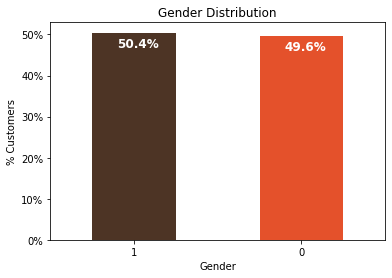

In [112]:
ax = (dataset['gender'].value_counts()*100.0 /len(dataset)).plot(kind='bar', stacked=True, rot=0, color=['#4D3425','#E4512B'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
            weight = 'bold')

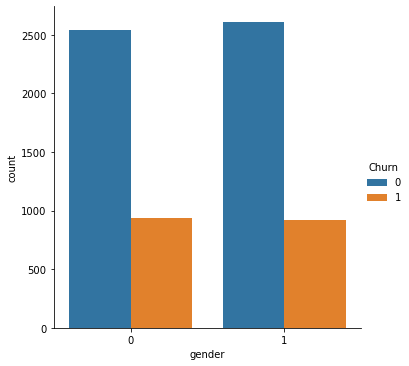

In [113]:
sns.catplot(x="gender", kind="count", hue="Churn", data=dataset, estimator=lambda x: sum(x==0)*100.0/len(x))

# Feature Selection
____________________________

## Split dataset to x and y

In [114]:
# Split the dataset to x and y
x_data = np.array(dataset.iloc[:,:-1])
y_data = np.array(dataset.iloc[:,-1])

In [115]:
def evaluate_features_score(scores, threshold):
  features_score_table = []
  cnt = 0

  for i in range(len(scores)):
    if ((scores[i] >= threshold)):
      cnt += 1
      valid = "True"
    else:
      valid = "False"

    features_score_table.append([i, dataset.columns[i], scores[i], valid]) 
   
  print(tabulate(features_score_table, headers=["Feature Num.", "Feature Name", "Score", f">= {threshold}"], tablefmt="pipe"))

  print(f"\nThere are {cnt} features >= {threshold}\n")

  # Plot the score of each feature
  plt.bar([i for i in range(len(scores))], scores)
  plt.show()

## Chi-Square Test
when p-value obtained after conducting the test is **less than 0.05** that implies that the 2 variables are **dependent** (accept the Alternate hypothesis) and if the p-value is **greater that 0.05** that implies that the 2 variables are **independent** (accept the Null hypothesis)

|   Feature Num. | Feature Name     |          Score | >= 50   |
|---------------:|:-----------------|---------------:|:--------|
|              0 | gender           |      0.262688  | False   |
|              1 | SeniorCitizen    |    134.298     | True    |
|              2 | Partner          |     79.9457    | True    |
|              3 | Dependents       |    129.467     | True    |
|              4 | tenure           |  16178.6       | True    |
|              5 | PhoneService     |      0.0833633 | False   |
|              6 | MultipleLines    |     10.7932    | False   |
|              7 | InternetService  |      9.71895   | False   |
|              8 | OnlineSecurity   |    546.456     | True    |
|              9 | OnlineBackup     |    225.882     | True    |
|             10 | DeviceProtection |    187.372     | True    |
|             11 | TechSupport      |    518.178     | True    |
|             12 | StreamingTV      |      6.57018   | False   |
|             13 | Stream

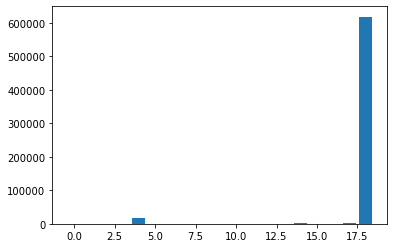

In [116]:
fs = SelectKBest(score_func=chi2 ,k='all')
x_selected = fs.fit_transform(x_data, y_data)

evaluate_features_score(fs.scores_, 50) # the score that implies that this feature is valid 
# print('Selected Features are : ' , fs.get_support())

## Mutual Information

|   Feature Num. | Feature Name     |      Score | >= 0.01   |
|---------------:|:-----------------|-----------:|:----------|
|              0 | gender           | 0          | False     |
|              1 | SeniorCitizen    | 0.0136605  | True      |
|              2 | Partner          | 0.00486276 | False     |
|              3 | Dependents       | 0.0117823  | True      |
|              4 | tenure           | 0.0701417  | True      |
|              5 | PhoneService     | 0.0029429  | False     |
|              6 | MultipleLines    | 0          | False     |
|              7 | InternetService  | 0.0530466  | True      |
|              8 | OnlineSecurity   | 0.0669188  | True      |
|              9 | OnlineBackup     | 0.0465512  | True      |
|             10 | DeviceProtection | 0.0417069  | True      |
|             11 | TechSupport      | 0.0685942  | True      |
|             12 | StreamingTV      | 0.0313734  | True      |
|             13 | StreamingMovies  | 0.0269763  | True

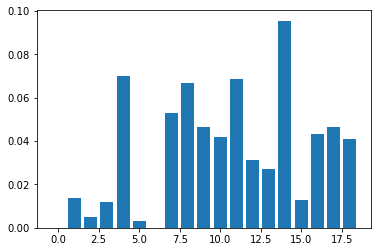

In [117]:
fs = SelectKBest(score_func=mutual_info_classif, k='all')
x_selected = fs.fit_transform(x_data, y_data)

evaluate_features_score(fs.scores_, 0.01) # the score that implies that this feature is valid 

## Wrapper Function

In [118]:
def select_features(score_method, num_of_features, x_data, y_data):
  """ Conduct the feature selection process """
  # Change scoring function used in the selection process
  if score_method == "chi2":
    score_func = chi2
  elif score_method == "mutual_info":
    score_func = mutual_info_classif

  fs = SelectKBest(score_func=score_func, k=num_of_features)
  x_data = fs.fit_transform(x_data, y_data)
  return x_data, fs

# Divide Dataset to Train & Test



In [119]:
def split_data(x_data, y_data):
  """ Splits the data to train and test """
  return train_test_split(x_data, y_data, test_size=0.2, shuffle=True, random_state=99)# 80% training and 20% test

In [120]:
x_train, x_test, y_train, y_test = split_data(x_data, y_data) 
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5608, 19)
(5608,)
(1402, 19)
(1402,)


# Logistic Regression Algorithm 
____________________________


## Model Training Using all Features

In [121]:
def train_logistic_regression_model():
  global models
  # Create a Logistic Regression Object, perform Logistic Regression
  log_reg_model = LogisticRegression(solver='newton-cg', C=1, random_state=1, penalty='l2')
  log_reg_model.fit(x_train,y_train)
  
  x_selected, fs = select_features('chi2', "all", x_data, y_data)
  models["LOGISTIC_REGRESSION"] = [log_reg_model, fs]
  save_model("LOGISTIC_REGRESSION")
  
  return evaluate_ml_model(log_reg_model, x_test, y_test)

if APP_MODE == "development":
  train_logistic_regression_model()

## Hyperparameters Tuning

In [122]:
if APP_MODE == "tunning":
  bestModel = hyperparameter_tuning(
    LogisticRegression(random_state=1, max_iter=400), 
    {
      "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
      "penalty" : ["l1", "l2"],
      "C" : np.logspace(-4, 4, 50)
    }
  )
  models["LOGISTIC_REGRESSION"] = bestModel


## Load/Save the model

In [123]:
if APP_MODE == "production":
  load_model("LOGISTIC_REGRESSION")
else:
  save_model("LOGISTIC_REGRESSION")

# SVM Algorithm 
____________________________


## Model Training Using all Features

In [124]:
# kernel to be set linear as it is binary class
def train_svm_model():
    global models
    svm_model = SVC(C=10, kernel='linear', gamma='scale')
    svm_model.fit(x_train, y_train) # Train the model

    # Get number of support vectors per class
    print(svm_model.n_support_)

    # Get support vectors themselves
    print(svm_model.support_vectors_)

    x_selected, fs = select_features('chi2', "all", x_data, y_data)
    models["SVM"] = [svm_model, fs]
    save_model("SVM")

    return evaluate_ml_model(svm_model, x_test, y_test)

if APP_MODE == "development":
  train_svm_model()

## Hyperparameters Tuning

In [125]:
if APP_MODE == "tunning":
  bestModel = hyperparameter_tuning(
    SVC(), 
    {
      "kernel" : ["linear", "rbf"],
      "C" : [50, 10, 1.0, 0.1, 0.01],
      "game" : ['scale','auto']
    }
  )
  models["SVM"] = bestModel

## Load/Save the model

In [126]:
if APP_MODE == "production":
  load_model("SVM")
else:
  save_model("SVM")

# Decision Tree ID3 Algorithm

____________________________


## Model Training Using all Features

In [127]:
def train_id3_mode():
  global models
  DTClassifier = DecisionTreeClassifier(criterion='entropy', max_depth=5)
  DTClassifier.fit(x_train,y_train)

  x_selected, fs = select_features('chi2', "all", x_data, y_data)
  models["DECISION_TREE_ID3"] = [DTClassifier, fs]
  save_model("DECISION_TREE_ID3")
  
  evaluate_ml_model(DTClassifier, x_test, y_test)

if APP_MODE == "development":
  train_id3_mode()

## Hyperparameters Tuning

In [128]:
if APP_MODE == "tunning":
  bestModel = hyperparameter_tuning(
    DecisionTreeClassifier(), 
    {
      "criterion" : ["entropy", "gini"],
      "max_depth" : range(5, 20)
    }
  )
  models["DECISION_TREE_ID3"] = bestModel

## Load/Save the Model

In [129]:
if APP_MODE == "production":
  load_model("DECISION_TREE_ID3")
else:
  save_model("DECISION_TREE_ID3")

# Random Forest [ Bonus Algorithm ]
____________________________


## Model Training Using all Features

In [130]:
def train_random_forest_model():
  global models
  model_rf = RandomForestClassifier(n_estimators=1000 , oob_score=True, n_jobs = -1, random_state=50, max_features="auto", max_leaf_nodes=30)
                                
  model_rf.fit(x_train, y_train)

  x_selected, fs = select_features('chi2', "all", x_data, y_data)
  models["RANDOM_FOREST_TREE"] = [model_rf, fs]
  save_model("RANDOM_FOREST_TREE")

  evaluate_ml_model(model_rf, x_test, y_test)

if APP_MODE == "development":
  train_random_forest_model()

## Load/Save the Model

In [131]:
if APP_MODE == "production":
  load_model("RANDOM_FOREST_TREE")
else:
  save_model("RANDOM_FOREST_TREE")

# Graphic User Interface (Mohy)
____________________________

In [132]:
from AppWindow_ui import Ui_AppWindow

class AppWindow(QMainWindow, Ui_AppWindow):

    def __init__(self):
        super().__init__()
        self.setupUi(self)
        self.UiComponentsEvent()
        self.show()

    # Set up all events in the UI components
    def UiComponentsEvent(self):
        self.trainBtn.clicked.connect(lambda:self.trainModel())
        self.testBtn.clicked.connect(lambda:self.testModel())
        self.predictBtn.clicked.connect(lambda:self.predict())
        
    def getSelectedModel(self):
        if self.linearRegressionBox.isChecked():
            return "LOGISTIC_REGRESSION"
        elif self.svmBox.isChecked():
            return "SVM"
        elif self.id3Box.isChecked():
            return "DECISION_TREE_ID3"
        elif self.randomForestBox.isChecked():
            return "RANDOM_FOREST_TREE"
        else:
            return "LOGISTIC_REGRESSION"

    def trainModel(self):
        if self.linearRegressionBox.isChecked():
            train_logistic_regression_model()
        elif self.svmBox.isChecked():
            train_svm_model()
        elif self.id3Box.isChecked():
            train_id3_mode()
        elif self.randomForestBox.isChecked():
            train_random_forest_model()
        else:
            return "LOGISTIC_REGRESSION"

    def testModel(self):
        self.scoreLbl.setText(str(evaluate_ml_model(models[self.getSelectedModel()][0], x_test, y_test))+"%")

    def predict(self):
        y_pred = deploy_model(self.getSelectedModel(), {
            "customerID" : self.customerIdInput.text(),
            "gender" : ["Male", "Female"][self.femaleBtn.isChecked()],
            "SeniorCitizen" : int(self.seniorCitizenBox.isChecked()),
            "Partner" : ["No", "Yes"][self.partnerBox.isChecked()],
            "Dependents" : ["No", "Yes"][self.dependentBox.isChecked()],
            "tenure" : str(self.tenureSpinBox.value()),
            "PhoneService" : ["No", "Yes"][self.phoneServiceBox.isChecked()],
            "MultipleLines" : self.multipleLinesCombo.currentText(), 
            "InternetService" : self.internetServiceCombo.currentText(),
            "OnlineSecurity" : self.onlineSecurityCombo.currentText(),
            "OnlineBackup" : self.onlineBackupCombo.currentText(),
            "DeviceProtection" : self.deviceProtectionCombo.currentText(),
            "TechSupport" : self.techSupportBoxCombo.currentText(),
            "StreamingTV" : self.streamingTVCombo.currentText(),
            "StreamingMovies" : self.StreamingMoviesCombo.currentText(),
            "Contract" : self.contractCombo.currentText(),
            "PaperlessBilling" : ["No", "Yes"][self.paperlessBillingBox.isChecked()],
            "PaymentMethod" : self.PaymentMethodCombo.currentText(),
            "MonthlyCharges" : self.monthlyChargesInput.text(),
            "TotalCharges" : self.totalChargesInput.text()})
        self.churnLbl.setText(y_pred[0])

----------  --------
Test Score  0.808845
Accuracy    0.808845
Precision   0.680782
Recall      0.551451
----------  -------- 

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1023
           1       0.68      0.55      0.61       379

    accuracy                           0.81      1402
   macro avg       0.76      0.73      0.74      1402
weighted avg       0.80      0.81      0.80      1402
 

----------  --------
Test Score  0.791726
Accuracy    0.791726
Precision   0.682008
Recall      0.430079
----------  -------- 

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1023
           1       0.68      0.43      0.53       379

    accuracy                           0.79      1402
   macro avg       0.75      0.68      0.70      1402
weighted avg       0.78      0.79      0.77      1402
 

----------  --------
Test Score  0.777461
Accuracy    0.777461
Precision   0.601208
Re

SystemExit: 0

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


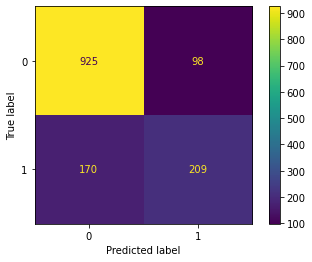

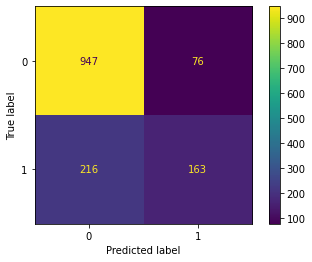

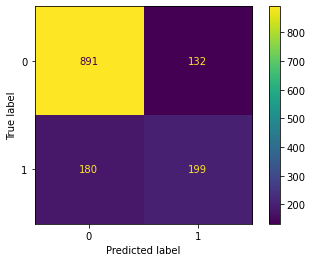

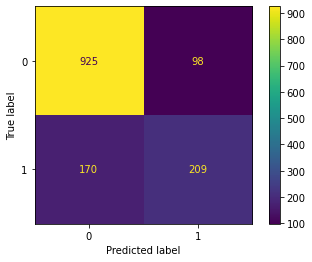

In [133]:
def main():
    App = QApplication(sys.argv)
    App.setStyle('Breeze') # ['Breeze', 'Oxygen', 'QtCurve', 'Windows', 'Fusion']

    appWindow = AppWindow()
    
    sys.exit(App.exec())

	
if __name__ == '__main__':
   main()